In [1]:
from keras.datasets import mnist
from keras.layers import Input,Conv2D,Activation,Dense,Lambda,Flatten,Embedding,PReLU,BatchNormalization,Bidirectional,LSTM
from keras.models import Model
import keras.backend as K
from tensorflow.keras.utils import to_categorical
import numpy as np
from keras.callbacks import EarlyStopping

import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
import random
from keras import Model
from keras.models import load_model
import numpy as np
import os
import pandas as pd

2021-12-20 22:50:40.119019: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-20 22:50:40.119076: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'non_gene_2':'./data/gene/non_gene_2.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed',
    'ATAC_hema_1':'./data/gene/ATAC_hema_1.bed',
    'ATAC_hema_2':'./data/gene/ATAC_hema_2.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Brain':'./data/gene/ATAC_Brain.bed'
    }
TSS_HK = []
with open(dic['TSS_HK'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['1']:
            TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))
# with open(dic['ATAC_hema_1'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
        


TSS_NonGene = []
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))
# with open(dic['ATAC_Bcell'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1','2','3'] and ll[2] == '0':
#             TSS_NonGene.append(TSS(ll[0],int(ll[1])))

bamfile = ps.AlignmentFile(dic['bam123'],'rb')

TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

TSSes_x = TSS_HK + TSS_NonGene
TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
TSSes_x = np.array(TSSes_x)
TSSes_y = np.array(TSSes_y)
TSSes_x = TSSes_x[perm[:len(perm)]]
TSSes_y = TSSes_y[perm[:len(perm)]]
labels = TSSes_y
up = 1000
down = 1000


In [5]:
#lstm
feature_matrix = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    win = 120
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    feature_matrix.append(feature_win)
feature_matrix = np.array(feature_matrix)

lstm_x = []
for mat in feature_matrix:
    lstm_x.append(mat)
lstm_x = np.array(lstm_x)


In [6]:
train_x = lstm_x[:int(len(lstm_x)*0.8)]
train_y = labels[:int(len(labels)*0.8)]
test_x = lstm_x[int(len(lstm_x)*0.8):]
test_y = labels[int(len(labels)*0.8):]

In [20]:
a = np.array([[1,2]])
print(a.shape,a[:,0].shape)

(1, 2) (1,)


In [7]:
feature_size = 2
num_classes = 2

inputs = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]))
x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
x = Flatten()(x)
x = Dense(300)(x)
x = PReLU()(x)
x = Dense(16)(x)
x = PReLU()(x)
x = Dense(feature_size)(x)
feature = PReLU(name='feature')(x)
out = Dense(num_classes,activation='softmax')(feature)


2021-12-20 22:52:58.300233: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-20 22:52:58.300286: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-20 22:52:58.300312: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jiay-virtual-machine): /proc/driver/nvidia/version does not exist
2021-12-20 22:52:58.300553: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
lambda_c=0
input_target = Input(shape=(1,))
centers = Embedding(num_classes, feature_size,name='centers')(input_target)
l2_loss = Lambda(lambda x: K.sum(K.square(x[0]-x[1][:,0]),1,keepdims=True),name='l2_loss')([feature, centers])
model_train = Model(inputs=[inputs, input_target], outputs=[out, l2_loss])
model_train.compile(optimizer='adam',
                          loss=["categorical_crossentropy",lambda y_true,y_pred:y_pred],
                          loss_weights=[1,lambda_c/2.],
                          metrics=["acc"])
model_predict = Model(inputs,out)
model_predict.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])


x_train = train_x
y_train = train_y
y_train_one_hot = to_categorical(y_train)
x_test = test_x
y_test = test_y
y_test_one_hot = to_categorical(y_test)
dummy_matrix1 = np.zeros((x_train.shape[0],1))
dummy_matrix2 = np.zeros((x_test.shape[0],1))

model_train.fit(x=[x_train,y_train],y=[y_train_one_hot,dummy_matrix1],
                     batch_size=512,epochs=100,verbose=0,validation_data=([x_test,y_test],[y_test_one_hot,dummy_matrix2]),
                     callbacks=[EarlyStopping(monitor="val_loss",patience=20)])


In [36]:
import tensorflow as tf
pp = model_predict(lstm_x)
print(pp.numpy())
# with tf.compat.v1.Session():
#     aa = pp.numpy()
#     print(aa)
# print(sess.run(pp))

[[0.9911972  0.00880282]
 [0.00215585 0.9978441 ]
 [0.9955474  0.00445258]
 ...
 [0.9974534  0.00254658]
 [0.9905813  0.00941875]
 [0.9794687  0.02053132]]


In [21]:
func=K.function([model_predict.input],[model_predict.get_layer('feature').output])
test_features= func([x_test])[0]
print(test_features.shape)

test_centers=np.dot(np.transpose(y_test_one_hot),test_features)
test_centers_count=np.sum(np.transpose(y_test_one_hot),axis=1,keepdims=True)
test_centers/=test_centers_count
print(test_centers.shape)

(551, 2)
(2, 2)


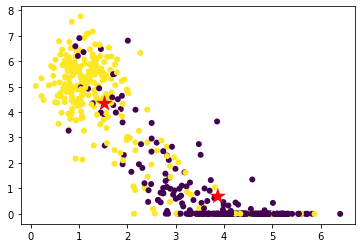

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(test_features[:,0],test_features[:,1],c=y_test,edgecolor="none")
plt.scatter(test_centers[:,0],test_centers[:,1],c="red",marker="*",edgecolor="none",s=300)
# plt.colorbar()
plt.show()